Here we will demonstrate how to generate dynamic responses to any arbitrary visual stimuli from a trained model

---

First, let's create a visual stimulus where we present 2 static images for 500 ms each. Before and after each image, we'll place blanks (gray screens).

In [1]:
# Let's load some example images from the upstream pipeline

import numpy as np
from foundation.virtual.bridge import pipe_stim

images = pipe_stim.StaticImage.Image & 'image_class="imagenet" and image_id in (0, 1)'
images

Connecting ewang@at-database.ad.bcm.edu:3306


image_class,image_id image id,image actual image
imagenet,0,=BLOB=
imagenet,1,=BLOB=


In [2]:
# ...and fetch those image arrays

images = images.fetch("image", order_by=images.primary_key)
images = np.stack(images, axis=0)
images.shape

(2, 144, 256)

In [3]:
# Let's create 5 frames and times for the images and blanks

# 5 frames -- (144 x 256)
frames = np.full([5, 144, 256], 128, dtype=np.uint8) 

# 1st frame at 0s, 2nd at 0.5s, 3rd at 1s, etc..
times = [0, 0.5, 1, 1.5, 2] 

# ...and let's insert our images into the 2nd and 4th frames
frames[1] = images[0]
frames[3] = images[1]

In [4]:
# Finally, let's create a video from those frames

from foundation.utils.video import Video

video = Video.fromarray(frames, times=times)

In [ ]:
# This will animate the video and display it in the jupyter notebook

video.animate()

---

Now that we have a video to present a model, let's load up an example model. A model is specified by 3 things:
- `data_id` (stimuli, responses, etc.. used to train the model)
- `network_id` (neural network architecture)
- `instance_id` (training/instantiation method)

In [5]:
# This is the key for an example model

key = {
    "data_id": "ee8e6dfc05a126b4e5837dc4c65d94f1",
    'network_id': "c552b6fe7026bf4d2b2883e95b2eea79",
    "instance_id": "62d795a533a01cbdfc13d9c760cae29c",
}

In [6]:
# Using the `data_id`, let's load up information about the data such as sampling period (in seconds)

from foundation.fnn.data import Data

period = (Data & key).link.compute.sampling_period
period

0.03333333333333333

In [7]:
# ...and the offset (in seconds) of the neuronal/unit response

offset = (Data & key).link.compute.unit_offset
offset

0.0

In [8]:
# ...and stimulus resolution (in pixels)

height, width = (Data & key).link.compute.resolution
height, width

(144, 256)

In [9]:
# ...and the method for stimulus resizing

resize_id = (Data & key).link.compute.resize_id
resize_id

'9b07f7038587b888bc1312559f48d163'

In [10]:
# And we'll resize our video to the appropriate height and width for our model

from foundation.utility.resize import Resize

rkey = {"resize_id": resize_id}
rvideo = (Resize & rkey).link.resize(video=video, height=height, width=width)

# the resized video's height and width
rvideo.height, rvideo.width

(144, 256)

In [11]:
# Now that we have a stimulus to present to our model, let's load the actual model using the GPU (cuda)

from foundation.fnn.model import Model

model = (Model & key).model(device="cuda")

In [12]:
# With the resized video, let's create a stimulus generator

stimuli = rvideo.generate(period=period)

In [13]:
# And we'll feed that to our model, collecting responses in a list

responses = []

for r in model.generate_response(stimuli=stimuli):
    
    responses.append(r)

Video Frames: 100% 61/61 [00:00<00:00, 87.71it/s] 


In [14]:
# Let's stack those responses in a 2D matrix

responses = np.stack(responses, axis=0)
responses.shape

(61, 8509)

In [15]:
# This is the shape of our matrix

frames, units = responses.shape

In [16]:
# Since we have the number of frames, the sampling period and offset, 
# we know the timing of the response

response_times = np.arange(frames) * period + offset

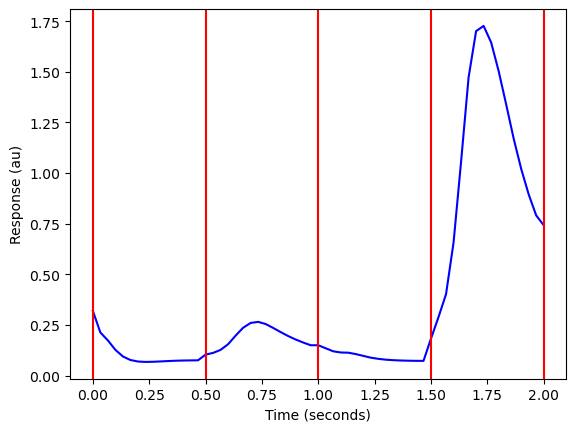

In [17]:
# Let's plot the response for one of neurons/units

from matplotlib import pyplot as plt

# Let's select the 11th (index=10) unit and plot its response
unit_repsonse = responses[:, 10]
plt.plot(response_times, unit_repsonse, c='blue')

# We'll also plot the onset times of each of stimulus frames
for stim_time in video.times:
    plt.axvline(stim_time, c='red')
    
plt.xlabel("Time (seconds)")
plt.ylabel("Response (au)")
plt.show()